### Data preprocessing


To get started, let's read in data from last five Stack Overflow surveys

In [140]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

df16 = pd.read_csv('./data/2016 Stack Overflow Survey Responses.csv', low_memory=False)
df17 = pd.read_csv('./data/2017_survey_results_public.csv', low_memory=False)
df18 = pd.read_csv('./data/2018_survey_results_public.csv', low_memory=False)
df19 = pd.read_csv('./data/2019_survey_results_public.csv', low_memory=False)
df20 = pd.read_csv('./data/2020_survey_results_public.csv', low_memory=False)


Now let's take a look at our first question: How the technology has evolved over these years?
The popularity of programming languages can be considered one of the main determinants of changes in IT.

In [141]:
#Shapes of dataframes and labels of columns shows how the survey has changed over the years.
print(df16.shape, df17.shape, df18.shape, df19.shape, df20.shape)
print('\n16Y: \n', df16.columns[:5])
print('\n17Y: \n', df17.columns[:5])
print('\n18Y: \n', df18.columns[:5])
print('\n19Y: \n', df19.columns[:5])
print('\n20Y: \n', df20.columns[:5])
print('\n17Y&18Y&19Y: \n', set(df17.columns).intersection(set(df18.columns), set(df19.columns), set(df20.columns)))

(56030, 66) (51392, 154) (98855, 129) (88883, 85) (64461, 61)

16Y: 
 Index(['Unnamed: 0', 'collector', 'country', 'un_subregion', 'so_region'], dtype='object')

17Y: 
 Index(['Respondent', 'Professional', 'ProgramHobby', 'Country', 'University'], dtype='object')

18Y: 
 Index(['Respondent', 'Hobby', 'OpenSource', 'Country', 'Student'], dtype='object')

19Y: 
 Index(['Respondent', 'MainBranch', 'Hobbyist', 'OpenSourcer', 'OpenSource'], dtype='object')

20Y: 
 Index(['Respondent', 'MainBranch', 'Hobbyist', 'Age', 'Age1stCode'], dtype='object')

17Y&18Y&19Y: 
 {'Gender', 'Respondent', 'Country'}


In [142]:
#Number of columns and column names has been chenged
#It's necessary to define which collumn contains data related to technology
#e.g. C++, Java, JavaScript and Python

for n,d in {'df16': df16, 'df17': df17, 'df18': df18, 'df19': df19, 'df20': df20}.items():
    print(n, ':')
    for l in ['C++', 'Java', 'JavaScript', 'Python']:
        print(l, d.columns[d.apply(lambda x: x == l).any()])

df16 :
C++ Index(['tech_do', 'tech_want'], dtype='object')
Java Index(['tech_do', 'tech_want'], dtype='object')
JavaScript Index(['tech_do', 'tech_want'], dtype='object')
Python Index(['tech_do', 'tech_want'], dtype='object')
df17 :
C++ Index(['HaveWorkedLanguage', 'WantWorkLanguage'], dtype='object')
Java Index(['HaveWorkedLanguage', 'WantWorkLanguage'], dtype='object')
JavaScript Index(['HaveWorkedLanguage', 'WantWorkLanguage'], dtype='object')
Python Index(['HaveWorkedLanguage', 'WantWorkLanguage'], dtype='object')
df18 :
C++ Index(['LanguageWorkedWith', 'LanguageDesireNextYear'], dtype='object')
Java Index(['LanguageWorkedWith', 'LanguageDesireNextYear'], dtype='object')
JavaScript Index(['LanguageWorkedWith', 'LanguageDesireNextYear'], dtype='object')
Python Index(['LanguageWorkedWith', 'LanguageDesireNextYear'], dtype='object')
df19 :
C++ Index(['LanguageWorkedWith', 'LanguageDesireNextYear'], dtype='object')
Java Index(['LanguageWorkedWith', 'LanguageDesireNextYear'], dtype='obj

In [143]:
#resonses related to programming languages are placed in one column for each year
#but these columns has different names:
#2016: tech_do, tech_want
#2017: HaveWorkedLanguage, WantWorkLanguage
#2018/2019/2020: LanguageWorkedWith, LanguageDesireNextYear

#Now it is possible to count the popularity of languages in this survey (f.e. for 2016 and 2020):

print('df16: ', df16['tech_do'].value_counts())
print('\ndf20: ', df19['LanguageWorkedWith'].value_counts())

df16:  Java                                                                         843
C#                                                                           606
C#; JavaScript; SQL; SQL Server                                              561
Android; Java                                                                515
Python                                                                       501
                                                                            ... 
Hadoop; JavaScript; LAMP; PHP; Python; Salesforce; Spark; SQL                  1
Arduino / Raspberry Pi; C#; JavaScript; MongoDB; Node.js; SQL; SQL Server      1
C; C++; Cloud (AWS, GAE, Azure, etc.); Java; Node.js; Python; SQL              1
Android; C++; Python; Ruby; SQL                                                1
iOS; JavaScript; PHP; SQL; SQL Server; Swift                                   1
Name: tech_do, Length: 19139, dtype: int64

df20:  HTML/CSS;JavaScript;PHP;SQL                        

In [144]:
#Some respondents seem to use more than one language
#the column representing the language selection should be split into separate columns for each language

def split_by(df, col, splitter):
    dummies = {}
    size = df.shape[0]
    for i, el in enumerate(df[col]):
        if pd.isna(el):
            continue
        for l in el.replace(' ', '').split(splitter):
            if l in dummies:
                dummies[l][i] = 1
            else:
                dummies[l] = [0]*size
    return pd.DataFrame(dummies)

df1 = pd.DataFrame({
    '16Y': split_by(df16, 'tech_do', ';').sum(),
    '17Y': split_by(df17, 'HaveWorkedLanguage', ';').sum(),
    '18Y': split_by(df18, 'LanguageWorkedWith', ';').sum(),
    '19Y': split_by(df19, 'LanguageWorkedWith', ';').sum(),
    '20Y': split_by(df20, 'LanguageWorkedWith', ';').sum()
             })

df2 = pd.DataFrame({
    '16Y': split_by(df16, 'tech_want', ';').sum(),
    '17Y': split_by(df17, 'WantWorkLanguage', ';').sum(),
    '18Y': split_by(df18, 'LanguageDesireNextYear', ';').sum(),
    '19Y': split_by(df19, 'LanguageDesireNextYear', ';').sum(),
    '20Y': split_by(df20, 'LanguageDesireNextYear', ';').sum()
             })

<AxesSubplot:>

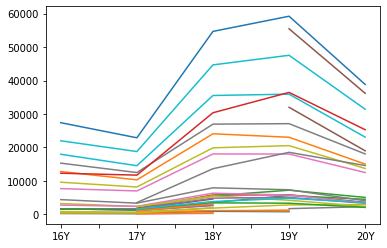

In [145]:
#draw the data
df1.T.plot(legend=False)

In [146]:
#This graph looks quite strange. It shows some problems in the data:

In [147]:
#1.the different number of respondents in subsequent years affects the total number of responses
df1.sum()

16Y    225033.0
17Y    138629.0
18Y    485630.0
19Y    440477.0
20Y    287979.0
dtype: float64

In [148]:
#2.some languages are not polled every year.
df1.loc[df1.isna().any(axis=1) == True]

,16Y,17Y,18Y,19Y,20Y
Android,8600.0,NaN,NaN,NaN,NaN
AngularJS,8822.0,NaN,NaN,NaN,NaN
Arduino/RaspberryPi,3796.0,NaN,NaN,NaN,NaN
Assembly,NaN,1822.0,5759.0,5832.0,3552.0
Bash/Shell,NaN,NaN,31171.0,NaN,NaN
Bash/Shell/PowerShell,NaN,NaN,NaN,31990.0,18979.0
CSS,NaN,NaN,50978.0,NaN,NaN
Cassandra,662.0,NaN,NaN,NaN,NaN
Clojure,555.0,390.0,1031.0,1253.0,NaN
"Cloud(AWS,GAE,Azure,etc.)",4628.0,NaN,NaN,NaN,NaN


In [149]:
#Most of this omitted data is due to the mixing of languages with tools and frameworks in the 2016 survey:
#Android, Hadoop, MongoDB, iOS, WordPress etc.,
#and some may be interesting as they only have a one year gap:
#Assembly, Clojure, Dart, F#, Haskel, Perl, TypeScript, VBA

In [150]:
#drop all the data that has more than one NaN
df1.dropna(inplace=True, thresh=4)
df2.dropna(inplace=True, thresh=4)
print(df1)

                 16Y      17Y      18Y      19Y      20Y
Assembly         NaN   1822.0   5759.0   5832.0   3552.0
C             7677.0   6973.0  18041.0  18016.0  12486.0
C#           15282.0  12475.0  26953.0  27096.0  18040.0
C++           9588.0   8154.0  19871.0  20523.0  13706.0
Clojure        555.0    390.0   1031.0   1253.0      NaN
Dart           221.0    144.0      NaN   1682.0   2279.0
F#             483.0    456.0   1114.0    972.0      NaN
Go            1546.0   1556.0   5531.0   7200.0   5037.0
Haskell        812.0    648.0   1960.0      NaN   1221.0
Java         17941.0  14523.0  35520.0  35916.0  23073.0
JavaScript   27384.0  22874.0  54685.0  59218.0  38821.0
Objective-C   3201.0   2348.0   5509.0   4190.0   2339.0
PHP          12779.0  10289.0  24070.0  23029.0  15006.0
Perl          1623.0   1584.0   3279.0      NaN   1795.0
Python       12281.0  11703.0  30358.0  36442.0  25286.0
R             1631.0   1633.0   4812.0   5047.0   3287.0
Ruby          4382.0   3323.0  

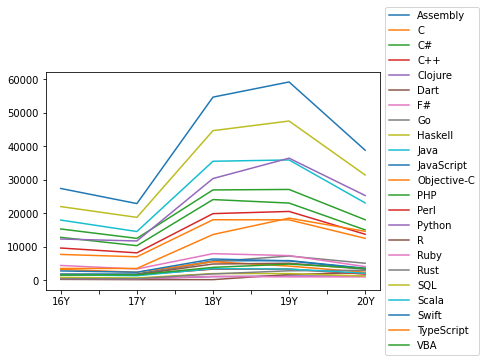

In [151]:
#filling gaps with adjacent data
df1 = df1.ffill(axis=1).bfill(axis=1)
df2 = df2.ffill(axis=1).bfill(axis=1)
df1.T.plot().legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [152]:
#calculating the relative popularity of programming languages:
df1 = (df1/df1.sum())
df2 = (df2/df2.sum())

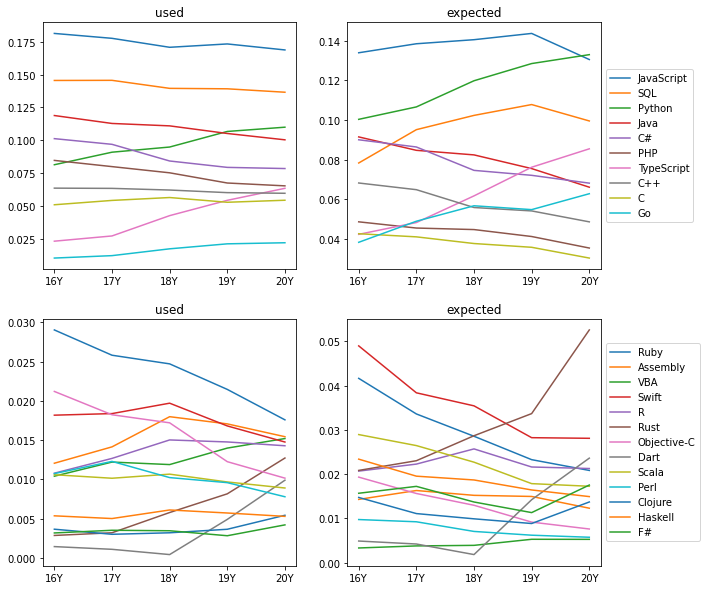

In [153]:
#drawing the common graph for the language used and the desired language for the 10 most popular and the rest
cmp = pd.concat([df1,df2], keys=['current', 'wanted'], axis=1).sort_values(('current','20Y'), ascending=False)
fig, axs = plt.subplots(2, 2)
cmp['current'][:10].T.plot(ax=axs[0,0], figsize=(10,10), legend= False, title='used')
cmp['current'][10:].T.plot(ax=axs[1,0], figsize=(10,10), legend= False, title='used')
cmp['wanted'][:10].T.plot(ax=axs[0,1], figsize=(10,10), title='expected').legend(loc='center left', bbox_to_anchor=(1, 0.5))
cmp['wanted'][10:].T.plot(ax=axs[1,1], figsize=(10,10), title='expected').legend(loc='center left', bbox_to_anchor=(1, 0.5))

These four graphs show change in market application and developer expectations of programming languages.
The top ten languages are shown first, followed by the others. The charts in first row show that in the group of the ten most popular languages in 2020 only three were gaining interest over last five years in comparison to the others: Python, TypeScript and Go. Especially interesting is the case of Python because if we consider that SQL rather isn't general purpose language than it looks like Python is now the second widely known and frequently used language and it overtook in five years: PHP, C# and Java.
From the second row of graphs you can see that there are two "winners": Rust and Dart. These two languages also made great progress and gained lot of interest and applications.

==================================================================================================================

In [154]:
df20.columns

Index(['Respondent', 'MainBranch', 'Hobbyist', 'Age', 'Age1stCode', 'CompFreq',
       'CompTotal', 'ConvertedComp', 'Country', 'CurrencyDesc',
       'CurrencySymbol', 'DatabaseDesireNextYear', 'DatabaseWorkedWith',
       'DevType', 'EdLevel', 'Employment', 'Ethnicity', 'Gender', 'JobFactors',
       'JobSat', 'JobSeek', 'LanguageDesireNextYear', 'LanguageWorkedWith',
       'MiscTechDesireNextYear', 'MiscTechWorkedWith',
       'NEWCollabToolsDesireNextYear', 'NEWCollabToolsWorkedWith', 'NEWDevOps',
       'NEWDevOpsImpt', 'NEWEdImpt', 'NEWJobHunt', 'NEWJobHuntResearch',
       'NEWLearn', 'NEWOffTopic', 'NEWOnboardGood', 'NEWOtherComms',
       'NEWOvertime', 'NEWPurchaseResearch', 'NEWPurpleLink', 'NEWSOSites',
       'NEWStuck', 'OpSys', 'OrgSize', 'PlatformDesireNextYear',
       'PlatformWorkedWith', 'PurchaseWhat', 'Sexuality', 'SOAccount',
       'SOComm', 'SOPartFreq', 'SOVisitFreq', 'SurveyEase', 'SurveyLength',
       'Trans', 'UndergradMajor', 'WebframeDesireNextYear',
  

In [187]:
intersections = [([('df20',c)], set(df20[c].value_counts().index)) for c in df20.columns if df20[c].dtype == 'object']
for n,d in {'df19': df19, 'df18': df18, 'df17': df17}.items():
    intersections = [i for i in [(s[0] + [(n,c)], s[1].intersection(set(d[c].value_counts().index))) for s in intersections for c in d.columns if d[c].dtype == 'object'] if len(i[1]) > 4]
for i in intersections:
    print(i[0], i[1])


[('df20', 'Country'), ('df19', 'Country'), ('df18', 'Country'), ('df17', 'Country')] {'Liechtenstein', 'United States', 'Bangladesh', 'Taiwan', 'Sri Lanka', 'Switzerland', 'China', 'Bhutan', 'New Zealand', 'Madagascar', 'Egypt', 'Angola', 'Bahrain', 'Nigeria', 'Antigua and Barbuda', 'Guatemala', 'Iraq', 'Trinidad and Tobago', 'Tunisia', 'Portugal', 'India', 'Yemen', 'Hungary', 'Mongolia', 'Oman', 'Romania', 'Honduras', 'Pakistan', 'Austria', 'Cameroon', 'Cape Verde', 'Ireland', 'Czech Republic', 'Lithuania', 'Andorra', 'Philippines', 'United Kingdom', 'Iceland', 'Guyana', 'Ukraine', 'Namibia', 'United Arab Emirates', 'Uzbekistan', 'Somalia', 'Zambia', 'South Africa', 'Georgia', 'Australia', 'Argentina', 'Ghana', 'Djibouti', 'Myanmar', 'Dominican Republic', 'Jamaica', 'Ecuador', 'Panama', 'Swaziland', 'Brazil', 'Nicaragua', 'Haiti', 'Botswana', 'Saudi Arabia', 'Afghanistan', 'Turkmenistan', 'Guinea', 'Malawi', 'Russian Federation', 'Kazakhstan', 'Indonesia', 'Croatia', 'Greece', 'Rwanda

In [188]:
intersections = [i for i in [(s[0] + [('df16',c)], s[1].intersection(set(df16[c].value_counts().index))) for s in intersections for c in df16.columns if df16[c].dtype == 'object'] if len(i[1]) > 4]
for i in intersections:
    print(i[0], i[1])


[('df20', 'Country'), ('df19', 'Country'), ('df18', 'Country'), ('df17', 'Country'), ('df17', 'country')] {'Liechtenstein', 'United States', 'Bangladesh', 'Taiwan', 'Sri Lanka', 'Switzerland', 'China', 'Bhutan', 'New Zealand', 'Egypt', 'Madagascar', 'Bahrain', 'Angola', 'Nigeria', 'Guatemala', 'Iraq', 'Tunisia', 'Portugal', 'India', 'Yemen', 'Hungary', 'Mongolia', 'Oman', 'Romania', 'Honduras', 'Pakistan', 'Austria', 'Cameroon', 'Czech Republic', 'Lithuania', 'Andorra', 'Philippines', 'United Kingdom', 'Iceland', 'Guyana', 'Ukraine', 'Namibia', 'United Arab Emirates', 'Uzbekistan', 'Somalia', 'Zambia', 'South Africa', 'Georgia', 'Australia', 'Argentina', 'Ghana', 'Djibouti', 'Dominican Republic', 'Jamaica', 'Ecuador', 'Panama', 'Brazil', 'Nicaragua', 'Haiti', 'Botswana', 'Saudi Arabia', 'Afghanistan', 'Guinea', 'Malawi', 'Russian Federation', 'Kazakhstan', 'Indonesia', 'Croatia', 'Greece', 'Rwanda', 'Canada', 'Montenegro', 'Kuwait', 'Malta', 'Sudan', 'Poland', 'Uruguay', 'Algeria', 'Be

In [108]:
for n,d in {'df16': df16, 'df17': df17, 'df18': df18, 'df19': df19, 'df20': df20}.items():
    print(n, ':')
    for l in ['.Net', 'Node.js', 'TensorFlow']:
        print(l, d.columns[d.apply(lambda x: x == l).any()])

df16 :
.Net Index([], dtype='object')
Node.js Index(['tech_do', 'tech_want'], dtype='object')
TensorFlow Index([], dtype='object')
df17 :
.Net Index([], dtype='object')
Node.js Index(['HaveWorkedFramework', 'WantWorkFramework'], dtype='object')
TensorFlow Index([], dtype='object')
df18 :
.Net Index([], dtype='object')
Node.js Index(['FrameworkWorkedWith', 'FrameworkDesireNextYear'], dtype='object')
TensorFlow Index(['FrameworkWorkedWith', 'FrameworkDesireNextYear'], dtype='object')
df19 :
.Net Index([], dtype='object')
Node.js Index(['MiscTechWorkedWith', 'MiscTechDesireNextYear'], dtype='object')
TensorFlow Index(['MiscTechWorkedWith', 'MiscTechDesireNextYear'], dtype='object')
df20 :
.Net Index([], dtype='object')
Node.js Index(['MiscTechDesireNextYear', 'MiscTechWorkedWith'], dtype='object')
TensorFlow Index(['MiscTechDesireNextYear', 'MiscTechWorkedWith'], dtype='object')


In [107]:
_df16 = pd.concat([df16, split_by(df16, 'tech_do', ';'), split_by(df16, 'tech_want', ';').add_prefix('want_')], axis=1)
_df17 = pd.concat([df17, split_by(df17, 'HaveWorkedLanguage', ';'), split_by(df17, 'WantWorkLanguage', ';').add_prefix('want_')], axis=1)
_df18 = pd.concat([df18, split_by(df18, 'LanguageWorkedWith', ';'), split_by(df18, 'LanguageDesireNextYear', ';').add_prefix('want_')], axis=1)
_df19 = pd.concat([df19, split_by(df19, 'LanguageWorkedWith', ';'), split_by(df19, 'LanguageDesireNextYear', ';').add_prefix('want_')], axis=1)
_df20 = pd.concat([df20, split_by(df20, 'LanguageWorkedWith', ';'), split_by(df20, 'LanguageDesireNextYear', ';').add_prefix('want_')], axis=1)

In [109]:
for l in ['Python', 'Java', 'C++', 'JavaScript']:
    print(_df16.loc[_df16[l] == 1]['tech_do'].apply(lambda x: l in x).all())
    print(_df17.loc[_df17[l] == 1]['HaveWorkedLanguage'].apply(lambda x: l in x).all())
    print(_df18.loc[_df18[l] == 1]['LanguageWorkedWith'].apply(lambda x: l in x).all())
    print(_df19.loc[_df19[l] == 1]['LanguageWorkedWith'].apply(lambda x: l in x).all())
    print(_df20.loc[_df20[l] == 1]['LanguageWorkedWith'].apply(lambda x: l in x).all())

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [110]:
for l in ['want_Python', 'want_Java', 'want_C++', 'want_JavaScript']:
    ll = l.split('_')[1]
    print(_df16.loc[_df16[l] == 1]['tech_want'].apply(lambda x: ll in x).all())
    print(_df17.loc[_df17[l] == 1]['WantWorkLanguage'].apply(lambda x: ll in x).all())
    print(_df18.loc[_df18[l] == 1]['LanguageDesireNextYear'].apply(lambda x: ll in x).all())
    print(_df19.loc[_df19[l] == 1]['LanguageDesireNextYear'].apply(lambda x: ll in x).all())
    print(_df20.loc[_df20[l] == 1]['LanguageDesireNextYear'].apply(lambda x: ll in x).all())

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [111]:
_df16.groupby('country')['Python'].sum().sort_values(ascending=False)[:10]

country
United States         3632
United Kingdom        1016
Germany                829
India                  648
Canada                 527
Poland                 373
France                 363
Russian Federation     353
Sweden                 304
Australia              265
Name: Python, dtype: int64

In [117]:
_df18.loc[_df18['Python'] == 1]['Country'].value_counts()['Poland']

609

In [211]:
python = pd.DataFrame({'16Y': _df16.groupby('country')['Python'].sum()/_df16['tech_do'].notna().sum(),
              '17Y': _df17.groupby('Country')['Python'].sum()/_df17['HaveWorkedLanguage'].notna().sum(),
              '18Y': _df18.groupby('Country')['Python'].sum()/_df18['LanguageWorkedWith'].notna().sum(),
              '19Y': _df19.groupby('Country')['Python'].sum()/_df19['LanguageWorkedWith'].notna().sum(),
              '20Y': _df20.groupby('Country')['Python'].sum()/_df20['LanguageWorkedWith'].notna().sum()
             })

<AxesSubplot:>

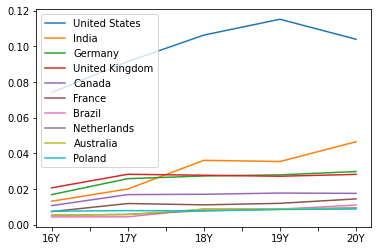

In [212]:
python.sort_values(by='20Y', ascending=False)[:10].T.plot()

In [133]:
for d in [df16, df17, df18, df19, df20]:
    print('----->')
    for c in d.columns:
        for t in ['Salary', 'salary', 'Comp', 'Currency', 'ountry']:
            if t in c: print(c)

----->
country
salary_range
salary_midpoint
----->
Country
CompanySize
CompanyType
UnderstandComputers
CompetePeers
AssessJobCompensation
ImportantHiringCompanies
Currency
StackOverflowCompanyPage
Salary
ExpectedSalary
----->
Country
CompanySize
Currency
Salary
SalaryType
ConvertedSalary
CurrencySymbol
HoursComputer
----->
Country
CurrencySymbol
CurrencyDesc
CompTotal
CompFreq
ConvertedComp
----->
CompFreq
CompTotal
ConvertedComp
Country
CurrencyDesc
CurrencySymbol


In [137]:
print('\ndf16: ', df16[['salary_range', 'salary_midpoint', 'country']].dropna())
print('\ndf17: ', df17[['Salary', 'Currency', 'Country']].dropna())
print('\ndf18: ', df18[['Salary', 'SalaryType', 'ConvertedSalary', 'Currency', 'CurrencySymbol', 'Country']].dropna())
print('\ndf19: ', df19[['CompTotal', 'CompFreq', 'ConvertedComp', 'CurrencyDesc', 'CurrencySymbol', 'Country']].dropna())
print('\ndf20: ', df20[['CompTotal', 'CompFreq', 'ConvertedComp', 'CurrencyDesc', 'CurrencySymbol', 'Country']].dropna())


df16:                salary_range  salary_midpoint      country
1        $40,000 - $50,000          45000.0  Afghanistan
3        Less than $10,000           5000.0  Afghanistan
6       More than $200,000         210000.0  Afghanistan
7        Less than $10,000           5000.0  Afghanistan
9        Less than $10,000           5000.0      Albania
...                    ...              ...          ...
56005  $110,000 - $120,000         115000.0      Uruguay
56006    Less than $10,000           5000.0   Uzbekistan
56007    Less than $10,000           5000.0   Uzbekistan
56008    Less than $10,000           5000.0    Venezuela
56009    Less than $10,000           5000.0      Vietnam

[41580 rows x 3 columns]

df17:                Salary                     Currency         Country
2      113750.000000  British pounds sterling (£)  United Kingdom
14     100000.000000  British pounds sterling (£)  United Kingdom
17     130000.000000             U.S. dollars ($)   United States
18      82

In [132]:
df17[['Currency', 'Country']].value_counts()

Currency                     Country       
U.S. dollars ($)             United States     5832
Indian rupees (?)            India             2146
British pounds sterling (£)  United Kingdom    2131
Euros (€)                    Germany           1900
Canadian dollars (C$)        Canada            1047
                                               ... 
Euros (€)                    Egypt                1
                             Costa Rica           1
                             China                1
                             Chile                1
Indian rupees (?)            Kuwait               1
Length: 423, dtype: int64

<AxesSubplot:>

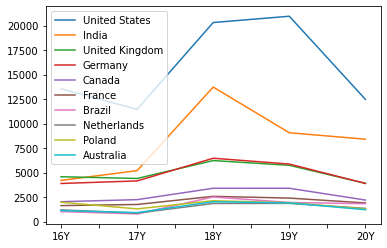

In [232]:
pd.DataFrame({'16Y': df16['country'].value_counts(),
              '17Y': df17['Country'].value_counts(),
              '18Y': df18['Country'].value_counts(),
              '19Y': df19['Country'].value_counts(),
              '20Y': df20['Country'].value_counts()
             }).dropna().astype('int32').sort_values(by='20Y', ascending=False)[:10].T.plot()

<AxesSubplot:>

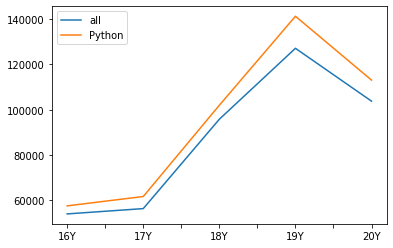

In [244]:
pd.DataFrame({'16Y': [df16['salary_midpoint'].mean(), _df16.loc[_df16['Python'] == 1]['salary_midpoint'].mean()],
              '17Y': [df17['Salary'].mean(), _df17.loc[_df17['Python'] == 1]['Salary'].mean()],
              '18Y': [df18['ConvertedSalary'].mean(), _df18.loc[_df18['Python'] == 1]['ConvertedSalary'].mean()],
              '19Y': [df19['ConvertedComp'].mean(), _df19.loc[_df19['Python'] == 1]['ConvertedComp'].mean()],
              '20Y': [df20['ConvertedComp'].mean(), _df20.loc[_df20['Python'] == 1]['ConvertedComp'].mean()]
             }, index=['all', 'Python']).T.plot()

<AxesSubplot:>

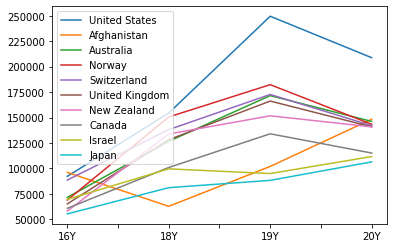

In [230]:
pd.DataFrame({'16Y': _df16.groupby('country')['salary_midpoint'].mean(),
#              '17Y': _df17.groupby('Country')['Salary'].mean(),
              '18Y': _df18.groupby('Country')['ConvertedSalary'].mean(),
              '19Y': _df19.groupby('Country')['ConvertedComp'].mean(),
              '20Y': _df20.groupby('Country')['ConvertedComp'].mean()
             }).dropna().astype('int32').sort_values(by='20Y', ascending=False)[:10].T.plot()

In [184]:
python_salary = pd.DataFrame({'16Y': _df16.loc[_df16['Python'] == 1].groupby('country')['salary_midpoint'].mean(),
              '17Y': _df17.loc[_df17['Python'] == 1].groupby('Country')['Salary'].mean(),
              '18Y': _df18.loc[_df18['Python'] == 1].groupby('Country')['ConvertedSalary'].mean(),
              '19Y': _df19.loc[_df19['Python'] == 1].groupby('Country')['ConvertedComp'].mean(),
              '20Y': _df20.loc[_df20['Python'] == 1].groupby('Country')['ConvertedComp'].mean()
             }).dropna().astype('int32').sort_values(by='20Y', ascending=False)

<AxesSubplot:>

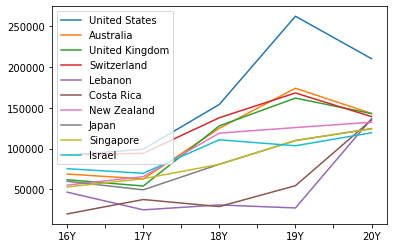

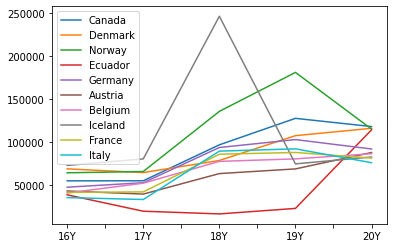

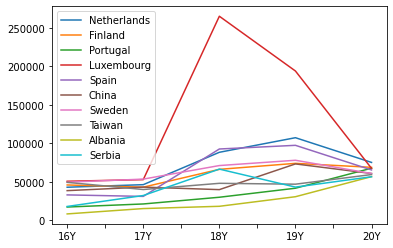

In [210]:
python_salary[:10].T.plot()
python_salary[10:20].T.plot()
python_salary[20:30].T.plot()

United States     5964
India             2670
Germany           1712
United Kingdom    1621
Canada            1011
France             833
Brazil             635
Netherlands        544
Australia          524
Poland             509
Name: Country, dtype: int64

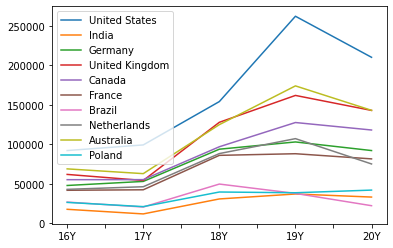

In [227]:
python_salary.loc[_df20.loc[_df20['Python'] == 1]['Country'].value_counts()[:10].index].T.plot()
_df20.loc[_df20['Python'] == 1]['Country'].value_counts()[:10]

<AxesSubplot:>

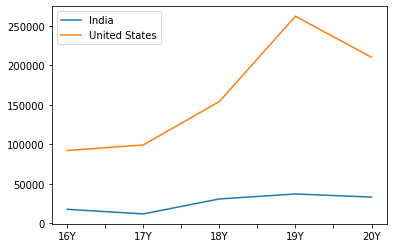

In [206]:
python_salary.loc[['India', 'United States']].T.plot()